
KORRELASJONER:
EUR/NOK og kilospris: 0.8691817958940623
USD/NOK og kilospris: 0.7444588740765481


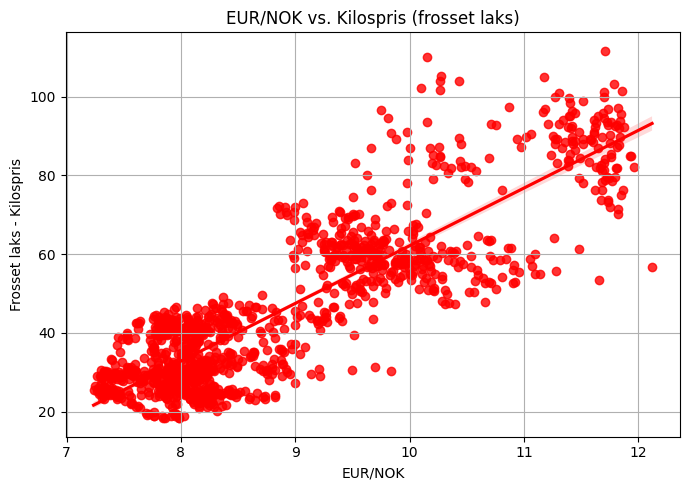

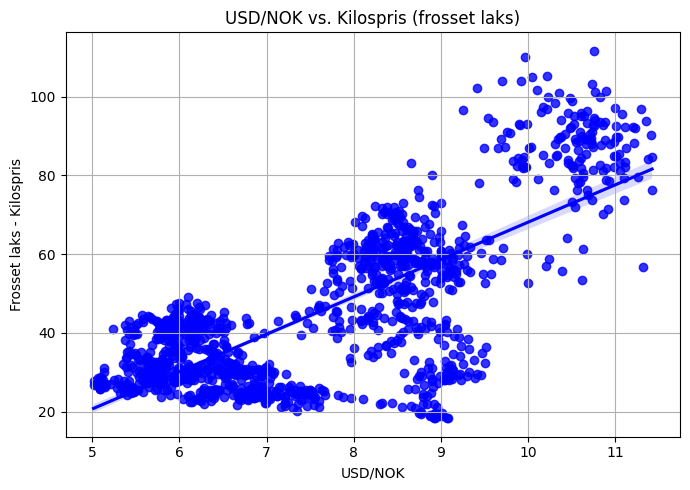

In [1]:
"""
    Denne filen analyserer sammenhengen mellom valutakursene euro og dollar sammen med eksportprisen på frosset laks.

    Datasettet hentes fra to ulike API-er:
-   Valutakurser (EUR/NOK og USD/NOK) hentes fra Norges Bank.
-   Eksportpriser på laks hentes fra SSBs API (tabell 03024).

    Filen består av tre hoveddeler:
    Koden henter å behandler data med funksjonene `hent_valutakurs`, `hent_eksportdata` og `hent_og_slå_sammen`. Disse samler inn og kombinerer valutadata med eksportdata uke for uke.
    Videre brukes visualiseringene `interaktiv_valuta_vs_pris` og `scatter_korrelasjon_plot` for å vise sammenhengen mellom valutakurser og kilospris på frosset laks.
    Til slutt lages en analyse for å regne korrelasjonen mellom hver valutakurs og eksportpris.

    Målet med denne filen er å vurdere om og hvordan valutakursene kan påvirke eksportprisen på frosset laks. 
    Dette gir innsikt i markedet og  økonomisk risiko knyttet til valutaen i eksportnæringen.
"""


import requests
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns


# Datahenting, valutakurs

def hent_valutakurs(par, navn):
    url = f"https://data.norges-bank.no/api/data/EXR/B.{par}.SP?format=sdmx-json&startPeriod=2000-01-01&endPeriod=2025-04-08"
    response = requests.get(url)
    data = response.json()

    dates = data['data']['structure']['dimensions']['observation'][0]['values']
    series_key = list(data['data']['dataSets'][0]['series'].keys())[0]
    observations = data['data']['dataSets'][0]['series'][series_key]['observations']
    records = [(dates[int(k)]['id'], v[0]) for k, v in observations.items()]
    df = pd.DataFrame(records, columns=["Dato", navn])
    df["Dato"] = pd.to_datetime(df["Dato"])
    df[navn] = pd.to_numeric(df[navn])
    df["Ukedag"] = df["Dato"].dt.weekday
    df = df[df["Ukedag"] == 4].copy()
    df["År"] = df["Dato"].dt.isocalendar().year
    df["Ukenr"] = df["Dato"].dt.isocalendar().week
    df["UkeID"] = df["År"].astype(str) + "-" + df["Ukenr"].astype(str).str.zfill(2)
    return df[["UkeID", "Dato", navn]]


# Datahenting, eksportdata

def hent_eksportdata():
    url = "https://data.ssb.no/api/v0/no/table/03024/"
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    r = requests.post(url, json=query)
    data = r.json()

    from itertools import product
    dims = list(data["dimension"].keys())
    values = data["value"]
    dim_vals = [list(data["dimension"][d]["category"]["label"].values()) for d in dims]
    combos = list(product(*dim_vals))
    df = pd.DataFrame(combos, columns=dims)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"],
                               values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)",
                        "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    df_pivot["UkeID"] = df_pivot["År og ukenr."].str.replace("U", "-")
    return df_pivot

def hent_og_slå_sammen():
    df_usd = hent_valutakurs("USD.NOK", "USD/NOK")
    df_eur = hent_valutakurs("EUR.NOK", "EUR/NOK")
    df_pris = hent_eksportdata()
    df = df_usd.merge(df_eur, on=["UkeID", "Dato"])
    df = df.merge(df_pris[["UkeID", "Frosset laks - Kilospris"]], on="UkeID")
    return df.dropna()


# Visualisering 1 – interaktivt linjediagram

def interaktiv_valuta_vs_pris():
    """funksjonen viser et interaktivt linjediagram med valutakurser og kilopris samtidig."""
    df = hent_og_slå_sammen()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df["Dato"], y=df["USD/NOK"], name="USD/NOK", line=dict(color="blue")))
    fig.add_trace(go.Scatter(x=df["Dato"], y=df["EUR/NOK"], name="EUR/NOK", line=dict(color="red")))
    fig.add_trace(go.Scatter(x=df["Dato"], y=df["Frosset laks - Kilospris"], name="Kilospris", yaxis="y2", line=dict(color="green")))

    fig.update_layout(
        title="Valutakurs og kilospris (interaktiv)",
        xaxis_title="Dato",
        yaxis=dict(title="Valutakurs (NOK)"),
        yaxis2=dict(title="Kilospris (kr/kg)", overlaying="y", side="right"),
        legend=dict(x=0.01, y=0.99),
        hovermode="x unified"
    )
    fig.show()


# Visualisering 2 – scatter + korrelasjon 

def scatter_korrelasjon_plot():
    """denne funksjonen viser spredningsplott og regresjonslinjer for å undersøke hvor sterk korrelasjonen er ."""
    df = hent_og_slå_sammen()

    print("\nKORRELASJONER:")
    print("EUR/NOK og kilospris:", df["EUR/NOK"].corr(df["Frosset laks - Kilospris"]))
    print("USD/NOK og kilospris:", df["USD/NOK"].corr(df["Frosset laks - Kilospris"]))

    plt.figure(figsize=(7, 5))
    sns.regplot(data=df, x="EUR/NOK", y="Frosset laks - Kilospris", color="red")
    plt.title("EUR/NOK vs. Kilospris (frosset laks)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    sns.regplot(data=df, x="USD/NOK", y="Frosset laks - Kilospris", color="blue")
    plt.title("USD/NOK vs. Kilospris (frosset laks)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Kjør begge
if __name__ == "__main__":
    interaktiv_valuta_vs_pris()
    scatter_korrelasjon_plot()



Den første interaktive visualiseringen er et linjediagram som viser forholdet mellom kilospris og de to ulike valutakursene. Ettersom plotet består av mye data over flere år, er en interaktiv fremvisning til stor hjelp. Ved å dra pilen langs x-aksen ser man de ulike verdiene for dette tidspunktet. 
Den andre visualiseringen viser et scatterplot med korrelasjoner for kg-pris for frosset laks og de to valutaene USD og EUR. Det ble funnet en sterk positiv korrelasjon mellom EUR/NOK og kilospris, særlig for fersk laks (r ≈ 0.87). USD/NOK hadde også en positiv, men svakere korrelasjon. Den sterkere korrelasjonen med EUR/NOK kan tyde på at prisen på frosset laks har en større følsomhet for endringer i euroen enn for USD.

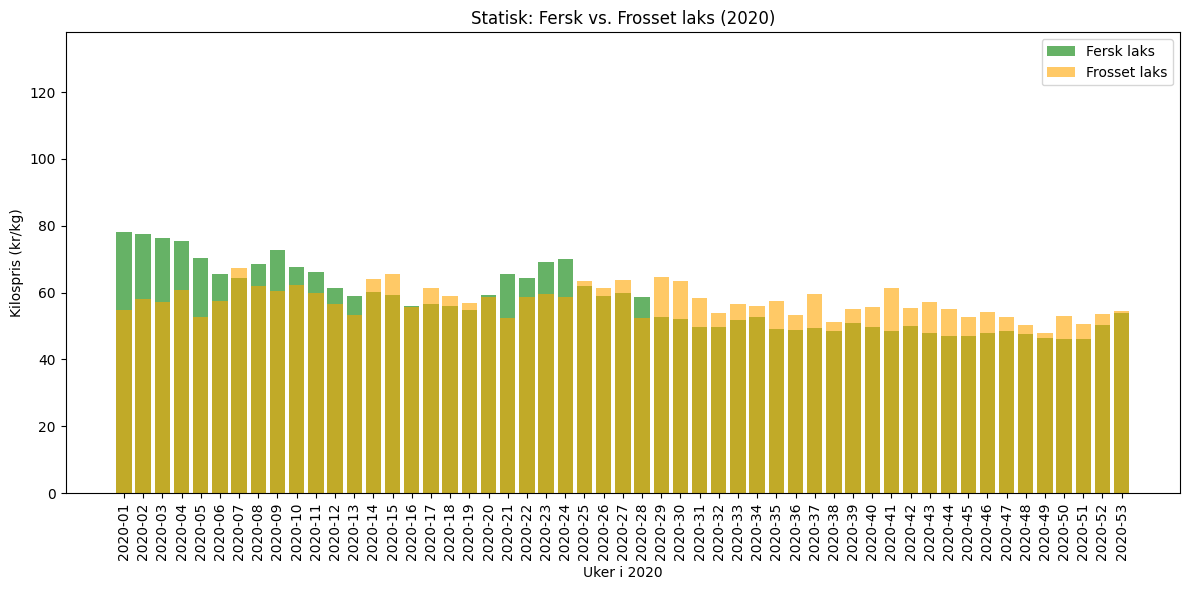

In [2]:
""" 
    Denne koden visualiserer og sammenligner ukentlig kilopris på fersk og frosset laks for et gitt år, år 2020 er brukt her.
    Grafen bruker søylediagrammer der begge laksetypene vises parallelt uke for uke, slik at prisforskjellene blir tydelige. 
    Denne visualiseringen viser tydelig om det er sesongvariasjoner og hvordan prisen mellom fersk og 
    frosset laks er. Dette kan brukes til å analysere trender og markedsrespons over tid.
"""


import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


# Henter eksportdata fra SSB

def hent_eksportdata():
    url = "https://data.ssb.no/api/v0/no/table/03024/"
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    r = requests.post(url, json=query)
    data = r.json()

    from itertools import product
    dims = list(data["dimension"].keys())
    values = data["value"]
    dim_vals = [list(data["dimension"][d]["category"]["label"].values()) for d in dims]
    combos = list(product(*dim_vals))
    df = pd.DataFrame(combos, columns=dims)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"],
                               values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)",
                        "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    df_pivot["UkeID"] = df_pivot["År og ukenr."].str.replace("U", "-")
    return df_pivot


# Plot 1 - Statisk søylediagram for år 2020

def sammenlign_statisk(df, valgt_år="2020", y_maks=None):
    df_år = df[df["År og ukenr."].str.contains(valgt_år)]
    if df_år.empty:
        print(f"Ingen data funnet for år {valgt_år}")
        return

    plt.figure(figsize=(12, 6))
    plt.bar(df_år["UkeID"], df_år["Fersk laks - Kilospris"], label="Fersk laks", color="green", alpha=0.6)
    plt.bar(df_år["UkeID"], df_år["Frosset laks - Kilospris"], label="Frosset laks", color="orange", alpha=0.6)
    plt.xlabel(f"Uker i {valgt_år}")
    plt.ylabel("Kilospris (kr/kg)")
    plt.title(f"Statisk: Fersk vs. Frosset laks ({valgt_år})")
    plt.xticks(rotation=90)
    if y_maks:
        plt.ylim(0, y_maks)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Plot 2 - Interaktiv søylediagram med dropdown for år

def sammenlign_interaktiv_med_dropdown(df, y_maks):
    df_melted = df.melt(
        id_vars=["UkeID", "År og ukenr."],
        value_vars=["Fersk laks - Kilospris", "Frosset laks - Kilospris"],
        var_name="Type",
        value_name="Kilospris"
    )
    df_melted = df_melted.dropna(subset=["Kilospris"])
    df_melted["År"] = df_melted["UkeID"].str.slice(0, 4)
    år_liste = sorted(df_melted["År"].unique())

    første_år = år_liste[0]
    df_start = df_melted[df_melted["År"] == første_år]

    fig = px.bar(
        df_start,
        x="UkeID",
        y="Kilospris",
        color="Type",
        barmode="group",
        title=f"Interaktiv: Fersk vs. Frosset laks ({første_år})",
        labels={"UkeID": "Uke", "Kilospris": "Kr/kg"},
        color_discrete_map={
            "Fersk laks - Kilospris": "green",
            "Frosset laks - Kilospris": "orange"
        }
    )

    # Dropdown-meny for år
    dropdown_buttons = []
    for år in år_liste:
        df_year = df_melted[df_melted["År"] == år]
        dropdown_buttons.append(
            dict(
                method="update",
                label=år,
                args=[
                    {"x": [df_year[df_year["Type"] == t]["UkeID"] for t in ["Fersk laks - Kilospris", "Frosset laks - Kilospris"]],
                     "y": [df_year[df_year["Type"] == t]["Kilospris"] for t in ["Fersk laks - Kilospris", "Frosset laks - Kilospris"]],
                     "type": "bar"},
                    {"title": f"Interaktiv: Fersk vs. Frosset laks ({år})"}
                ]
            )
        )

    fig.update_layout(
        updatemenus=[
            dict(
                buttons=dropdown_buttons,
                direction="down",
                showactive=True,
                x=0.01,
                y=1.15,
                xanchor="left",
                yanchor="top"
            )
        ],
        xaxis_tickangle=60,
        yaxis=dict(range=[0, y_maks], gridcolor="lightgrey"),
        bargap=0.15,
        plot_bgcolor="white"
    )

    fig.show()


# Kjører funksjoner

if __name__ == "__main__":
    df = hent_eksportdata()

    # Felles y-akse for begge plott for bedre sammenligning over alle år
    y_maks = df[["Fersk laks - Kilospris", "Frosset laks - Kilospris"]].max().max() * 1.1

    sammenlign_statisk(df, valgt_år="2020", y_maks=y_maks)
    sammenlign_interaktiv_med_dropdown(df, y_maks=y_maks)


Det første, statiske plotet, viser sammenligningen av kilospris mellom fersk og frosset laks i år 2020. 
Det andre, interaktive plottet, viser også sammenligningen av kilospris mellom fersk og frosset laks, men her kan man endre årstall etter eget ønske, samt dra pilen over søylene for å undersøke ulike verdier mer nøyaktig. 
Plot 1 gir en god visuell fremvisning av sammenheng for ett år, mens plot 2 gir en dypere forståelse og mer brukervennlig fremstilling for videre analyser.